__Tóm tắt SEMOS Train (70%) và Test (30%)__
- Dataset: Data_stock_VJC_VN.csv
***
__Kết quả evalutation__
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("../Dataset/Data_stock_VJC_VN.csv")

In [3]:
split = int(len(data)*0.7)
train = data[:split]
test = data[split:]
train_size = split
test_size = len(data)-split

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
train_high = scaler.fit_transform(np.array(train['high']).reshape(-1,1))
train_low = scaler.fit_transform(np.array(train['low']).reshape(-1,1))
train_close = scaler.fit_transform(np.array(train['close']).reshape(-1,1))

In [5]:
train_mean = (train_high-train_low)/2
train_hl = pd.DataFrame({'high': train_high.reshape(-1), 'low': train_low.reshape(-1)})
train_sd = train_hl.std(axis=1)
train_time = pd.to_datetime(train['time'], format='%Y-%m-%d')
train_doy = train_time.dt.dayofyear

In [6]:
# Get necessary values
doy = train_doy
obs = train_close
m = train_mean
s = train_sd

In [7]:
sin1 = np.sin(2 * np.pi * doy / 365.25)
sin2 = np.sin(4 * np.pi * doy / 365.25)
cos1 = np.cos(2 * np.pi * doy / 365.25)
cos2 = np.cos(4 * np.pi * doy / 365.25)

doys_array = np.hstack((np.ones((doy.shape[0], 1)), np.column_stack((sin1, sin2, cos1, cos2))))

In [8]:
train_df = pd.DataFrame({'close': obs.reshape(-1), 'mean': m.reshape(-1), 'sin1': sin1, 'sin2': sin2, 'cos1': cos1, 'cos2': cos2})

train_df['sin1_mean'] = train_df['sin1'] * train_df['mean']
train_df['sin2_mean'] = train_df['sin2'] * train_df['mean']
train_df['cos1_mean'] = train_df['cos1'] * train_df['mean']
train_df['cos2_mean'] = train_df['cos2'] * train_df['mean']

columns = ['sin1','sin2','cos1','cos2','mean','sin1_mean','sin2_mean','cos1_mean','cos2_mean']
x_train = train_df[columns]
y_train = train_df['close']

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

### Optimization

In [9]:
arr = np.concatenate([[model.intercept_], model.coef_])
pars = np.concatenate([arr, [0,0,0,0,0,1,0,0,0,0]])
pars

array([ 0.55595068, -0.0213712 ,  0.022579  ,  0.11515098,  0.01739359,
        3.05900918, -3.01809534,  1.88085694, -3.32371536, -4.83091647,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [10]:
def optim_fun(pars, obs, m, s, doys):
    MU = np.dot(doys, pars[:5]) + np.dot(doys, pars[5:10]) * m
    SIGMA = np.dot(doys, pars[10:15]) + np.dot(doys, pars[15:20]) * s
    
    # Calculate z
    z = (obs - MU) / SIGMA

    # Calculate CRPS
    crps = SIGMA * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi))

    # Return the sum of CRPS
    return np.sum(crps)

# Optimizing the function
res = minimize(optim_fun, pars, args=(obs.reshape(-1), m.reshape(-1), s, doys_array), method='L-BFGS-B')
res.x


array([ 0.56387424, -0.02499143,  0.03013603,  0.10679687,  0.00946587,
        3.57183677, -2.2873818 ,  2.67516978, -3.973298  , -5.36540068,
        0.18456743, -0.02960955, -0.0194896 ,  0.03833105, -0.0080641 ,
        1.37889354, -1.53910155,  2.03635345, -2.21078482, -2.75067225])

In [11]:
test_high = scaler.fit_transform(np.array(test['high']).reshape(-1,1))
test_low = scaler.fit_transform(np.array(test['low']).reshape(-1,1))
test_close = scaler.fit_transform(np.array(test['close']).reshape(-1,1))

test_mean = (test_high-test_low)/2
test_hl = pd.DataFrame({'high': test_high.reshape(-1), 'low': test_low.reshape(-1)})
test_sd = test_hl.std(axis=1)
test_time = pd.to_datetime(test['time'], format='%Y-%m-%d')
test_doy = test_time.dt.dayofyear

doy_test = test_doy
obs_test = test_close
m_test = np.array(test_mean)
s_test = np.array(test_sd).reshape(-1)

sin1_test = np.sin(2*np.pi*doy_test/365.25)
sin2_test = np.sin(4*np.pi*doy_test/365.25)
cos1_test = np.cos(2*np.pi*doy_test/365.25)
cos2_test = np.cos(4*np.pi*doy_test/365.25)

doys_test = np.hstack((np.ones((doy_test.shape[0], 1)), np.column_stack((sin1_test, sin2_test, cos1_test, cos2_test))))

In [12]:
mu = doys_test.dot(res.x[:5]) + doys_test.dot(res.x[5:10]) * m_test.reshape(-1)
sigma = np.exp(doys_test.dot(res.x[10:15]) + doys_test.dot(res.x[15:20]) * s_test)
prediction = np.random.normal(mu, sigma)
prediction

array([-0.53001096,  3.3475016 ,  1.80597865,  0.34881362,  2.39399034,
        4.15560879,  1.08630548, -2.35088331, -0.42562598,  3.49292884,
        1.790781  ,  2.18295657, -0.70284041,  1.0594751 ,  0.60843973,
       -0.81769964,  0.49715195,  0.31858245, -0.17314064, -1.7919148 ,
        0.12245182,  1.2039751 ,  2.82086772,  2.2276923 ,  1.06594684,
       -0.74196459, -0.00539017,  1.01211972,  2.97874765, -2.79541022,
        3.18531871, -0.13187423,  0.60503293,  3.01553562,  1.69109517,
        0.87163494,  2.14155555, -1.50081815, -1.33088065, -1.02641655,
        0.7857517 ,  1.40353642,  0.25481589,  1.90843165,  0.56701348,
        4.63111804,  2.08021074,  1.27563301,  0.69578266,  0.68865873,
        2.55191809, -1.39077343, -1.31216796,  0.83940971, -0.85301066,
        0.19869762,  0.54678447,  2.15549249, -0.02157606, -1.33926166,
        0.50231268, -0.11485319, -1.0688618 ,  0.6987687 , -0.02217565,
        2.27556546, -0.56370851,  1.30416724,  0.09987712,  1.95

### Visualization and evaluation

In [13]:
# Inverse
prediction = scaler.inverse_transform(np.array(prediction).reshape(-1,1))

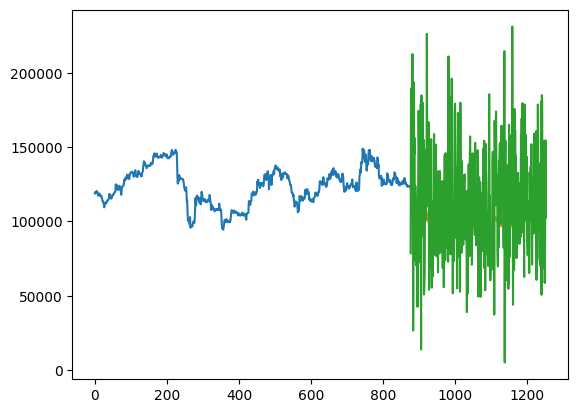

In [14]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
line1, = plt.plot(train_data_index, train['close'], label="Train")
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
line2, = plt.plot(test_data_index, test['close'], label="Test")
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
line3, = plt.plot(test_data_index, prediction, label="Predictions")
# predict_90_days_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)
# line4, = plt.plot(predict_90_days_index, predict_90_days[:90], label="Next 90 days")
# predict_60_days_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)
# line5, = plt.plot(predict_60_days_index, predict_90_days[:60], label="Next 60 days")
# predict_30_days_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
# line6, = plt.plot(predict_30_days_index, predict_90_days[:30], label="Next 30 days")
# plt.legend(handles=[line1, line2, line3, line6, line5, line4])
plt.savefig("SEMOS_VJC_73.png")
plt.show()

In [15]:
# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(test_close,prediction))

# Calculate MAPE
test_mape = mean_absolute_percentage_error(test_close, prediction) * 100

# Calculate MLSE
test_mlse = mean_squared_log_error(test_close, prediction)

print("RMSE:", test_rmse)
print("MAPE:", test_mape, "%")
print("MSLE:", test_mlse)

RMSE: 117927.9538214817
MAPE: 1.0696347147773621e+20 %
MSLE: 127.38825699768033


In [16]:
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+7, step=1)

# Create an array of 7 consecutive integers starting from last_index
x_next_7_days = np.array(range(last_index+1, last_index+8)).reshape(-1, 1)

# Predict the closing prices for the next 7 days
y_next_7_days = model.predict(x_next_7_days)

# Print the predicted closing prices for the next 7 days
print('Predicted closing prices for the next 7 days:')
print(y_next_7_days)

ValueError: X has 1 features, but LinearRegression is expecting 9 features as input.